In [71]:
### Data Analytics Project: Анализ продаж

# 1. Введение
# 📌 Цель проекта
# В данном проекте мы анализируем данные о продажах, проверяем гипотезы и строим визуализации.

In [72]:
# Скачаем необхадимые для работы библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sys

In [73]:
# Также загрузим инструменты для статистических тестов и кластеризации

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier    
from sklearn.svm import SVC  
from sklearn.tree import DecisionTreeClassifier  
from sklearn.metrics import classification_report
from scipy.stats import ttest_ind
from scipy import stats

In [74]:
# Загрузим SQL для запросов

import sqlite3

In [75]:
# Создаем таблицы



cnx = sqlite3.connect('shop_database.db')
personal_data = pd.read_sql_query("SELECT * FROM personal_data", cnx)
personal_data_coeffs = pd.read_sql_query("SELECT * FROM personal_data_coeffs", cnx)
purchases = pd.read_sql_query("SELECT * FROM purchases", cnx)
personal_data_losted = pd.read_csv('personal_data.csv')

In [76]:
# Просматриваем содержимое

In [77]:
personal_data.head()

,id,gender,age,education,city,country
0,0,0,36,среднее,1201,32
1,4,0,35,среднее,1134,32
2,6,1,52,среднее,1188,32
3,7,0,37,среднее,1198,32
4,9,0,48,среднее,1134,32


In [78]:
personal_data.size

535446

In [79]:
personal_data_coeffs.head()

,id,lbt_coef,ac_coef,sm_coef,personal_coef
0,0,5.078678,-0.307147,0.959027,0.5072
1,3,7.764766,-0.030225,0.794720,0.4304
2,4,4.569378,0.063693,0.820892,0.5072
3,6,8.150379,0.075200,0.836140,0.4304
4,7,5.188231,-0.000134,0.944113,0.5072


In [80]:
purchases.head()

,id,product,colour,cost,product_sex,base_sale,dt
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7
1,0,Стол Outventure,зелёный,1499,NaN,0,37
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,NaN,0,37
3,3,Бутсы мужские GSD Astro,белый,1599,1.0,0,13
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,NaN,0,27


In [81]:
purchases.size

5503820

In [82]:
personal_data_losted

,id,age,education,city,country
0,101492,32,среднее,1188,32
1,42690,20,высшее,1134,32
2,113001,27,среднее,1187,32
3,163654,49,высшее,1160,32
4,69523,44,среднее,1137,32
...,...,...,...,...,...
15743,135183,44,среднее,1134,32
15744,125993,46,среднее,1134,32
15745,167019,71,среднее,1134,32
15746,116355,32,среднее,1188,32


In [83]:
personal_data_losted.size

78740

In [84]:
purchases['product_sex'] = purchases.groupby('id')['product_sex'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

/var/folders/f3/w_srs2_148q2vhs8t74vnypc0000gn/T/ipykernel_35964/2601390010.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  purchases['product_sex'] = purchases.groupby('id')['product_sex'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


In [85]:
purchases

,id,product,colour,cost,product_sex,base_sale,dt
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7
1,0,Стол Outventure,зелёный,1499,0.0,0,37
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,0.0,0,37
3,3,Бутсы мужские GSD Astro,белый,1599,1.0,0,13
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,1.0,0,27
...,...,...,...,...,...,...,...
786255,178004,Полуботинки мужские Ascot Vortex,хаки/черный,7999,1.0,0,12
786256,178004,Кроссовки мужские Nike Air Max 90,черный/серый,24299,1.0,0,13
786257,178004,Кроссовки мужские Nike Air Max 90,черный/серый,24299,1.0,0,20
786258,178004,Пакет,коричневый,12,1.0,0,20


# Data Preparation

In [86]:
# Работу проводим только над клиентами из страны с кодом 32 (условия)



personal_data = personal_data[personal_data["country"] == 32]

## Таблица Purchases (Покупки)

In [87]:
# Смотрю на данные в столбце Colour (Цвет)



purchases["colour"].value_counts()

colour
черный                          131399
белый                            42520
чёрный                           37022
синий                            35268
темно-синий                      27257
                                 ...  
черный/красный/лаймовый              1
желтый/белый/черный                  1
черный/серый/зеленый/голубой         1
белый/золотой/красный                1
черный/циан                          1
Name: count, Length: 1693, dtype: int64

In [88]:
purchases['colour'].isna().sum()

119524

In [89]:
# Я вижу, что есть некоторые проблемы со значением цвета
# Самые популярные цвета - чёрный и черный, что является одним цветом. Исправляем



purchases = purchases.replace({'ё': 'е'}, regex=True)

In [90]:
purchases['colour'] = purchases['colour'].fillna('none')

In [91]:
# Также в данных цвета есть лишние пробелы, несколько цветов через косую черту
# Оставляю только одно название цвета и привожу в едую форму



purchases['colour'] = purchases['colour'].apply(lambda x: x.split('/')[0] if '/' in x else x.split('-')[1] if '-' in x else x)
purchases['colour'] = purchases['colour'].apply(lambda x: x.split('-')[1] if '-' in x else x)
purchases['colour'] = purchases['colour'].str.lower()

In [92]:
# Я хочу посмотреть, какие цвета наиболее популярны для каждого пола
# Для этого создам круговую диаграмму



col_a = purchases[purchases['product_sex']==1]
col_b = purchases[purchases['product_sex']==0]



    


In [93]:
col_1 = col_a[col_a.colour.notna()]
col_0 = col_b[col_b.colour.notna()]

In [94]:
# Для пола 1

color_counts1 = col_1.colour.value_counts()
top_colors1 = color_counts1.head(5)
other_count1 = color_counts1.iloc[5:].sum()
color_distribution1 = top_colors1.to_dict()
if other_count1 > 0:
    color_distribution1['Others'] = other_count1

In [95]:
# Для пола 0

color_counts0 = col_0.colour.value_counts()
top_colors0 = color_counts0.head(5)
other_count0 = color_counts0.iloc[5:].sum()
color_distribution0 = top_colors0.to_dict()
if other_count1 > 0:
    color_distribution0['Others'] = other_count0

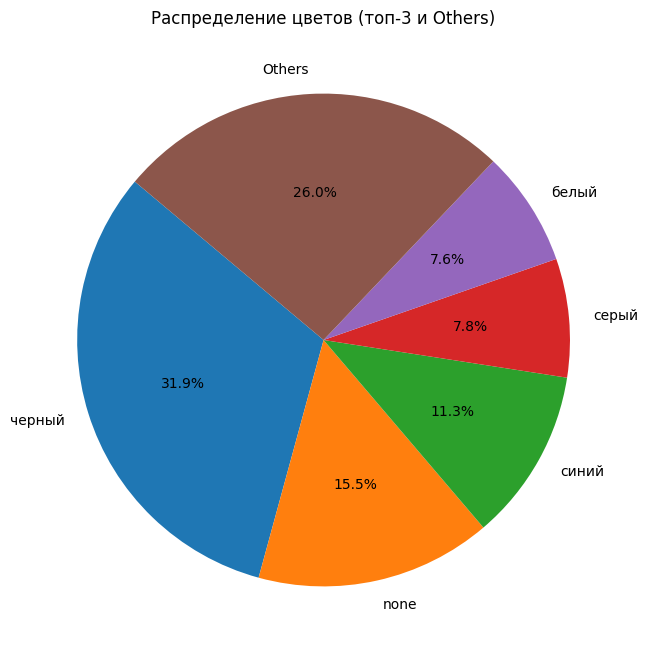

In [96]:
plt.figure(figsize=(8, 8))
plt.pie(
    color_distribution1.values(),
    labels=color_distribution1.keys(),
    autopct='%1.1f%%',
    startangle=140
)
plt.title("Распределение цветов (топ-3 и Others)")
plt.show()

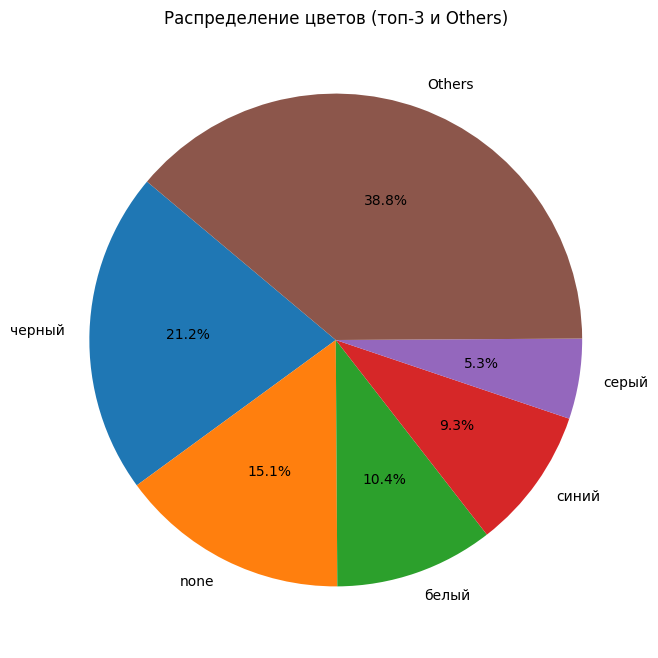

In [97]:
plt.figure(figsize=(8, 8))
plt.pie(
    color_distribution0.values(),
    labels=color_distribution0.keys(),
    autopct='%1.1f%%',
    startangle=140
)
plt.title("Распределение цветов (топ-3 и Others)")
plt.show()

In [98]:
# Я вижу, что для обоих полов, с большим отрывом, самым популярным является черный.
# Поэтому я заменяю модой все пропуски



purchases['colour'] = purchases['colour'].replace('none', purchases['colour'].mode()[0])

## Cоздаю новые таблицы

### Company

In [99]:
# Я заметил, что первое английское слово в описании продукта - это название компании.
# Сделаю отдельную колонку для названия компании. Для этого напишу функцию и создам колонку



def extract_first_english_word(description):  
    # Используем регулярное выражение для поиска первого английского слова  
    match = re.search(r'\b[a-zA-Z]+\b', description)  
    return match.group(0) if match else None  

# Создание новой колонки с первым английским словом  
purchases['company'] = purchases['product'].apply(extract_first_english_word).str.lower()

### Product_type

In [100]:
# Кроме того, первое слово в описании является самым важным и определяет сам продукт.
# Создаю столбец для типа продукта



purchases['product_type'] = purchases['product'].apply(lambda x: x.split()[0])
purchases

,id,product,colour,cost,product_sex,base_sale,dt,company,product_type
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый,13599,0.0,1,7,stern,Велосипед
1,0,Стол Outventure,зеленый,1499,0.0,0,37,outventure,Стол
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,0.0,0,37,outventure,Набор
3,3,Бутсы мужские GSD Astro,белый,1599,1.0,0,13,gsd,Бутсы
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,1.0,0,27,puma,Мяч
...,...,...,...,...,...,...,...,...,...
786255,178004,Полуботинки мужские Ascot Vortex,хаки,7999,1.0,0,12,ascot,Полуботинки
786256,178004,Кроссовки мужские Nike Air Max 90,черный,24299,1.0,0,13,nike,Кроссовки
786257,178004,Кроссовки мужские Nike Air Max 90,черный,24299,1.0,0,20,nike,Кроссовки
786258,178004,Пакет,коричневый,12,1.0,0,20,None,Пакет


### Price_category

In [101]:
# Разделю цены на 3 категории. Низкая цена, средняя и высокая



bins = [0, purchases['cost'].quantile(0.33), purchases['cost'].quantile(0.67), float('inf')]  
labels = ['low', 'medium', 'high']  
purchases['price_category'] = pd.cut(purchases['cost'], bins=bins, labels=labels, right=False)

In [102]:
purchases.isna().sum()

id                    0
product               0
colour                0
cost                  0
product_sex       53240
base_sale             0
dt                    0
company            5816
product_type          0
price_category        4
dtype: int64

In [103]:
# Вижу что есть немного данных с пропусками в столбце компании но из-за незначительности удаляю их и продолжаю работу



purchases = purchases[purchases['company'].notna()]
purchases

,id,product,colour,cost,product_sex,base_sale,dt,company,product_type,price_category
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый,13599,0.0,1,7,stern,Велосипед,high
1,0,Стол Outventure,зеленый,1499,0.0,0,37,outventure,Стол,low
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,0.0,0,37,outventure,Набор,high
3,3,Бутсы мужские GSD Astro,белый,1599,1.0,0,13,gsd,Бутсы,low
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,1.0,0,27,puma,Мяч,high
...,...,...,...,...,...,...,...,...,...,...
786254,178004,Жилет мужской IcePeak Manheim,черный,8699,1.0,0,9,icepeak,Жилет,high
786255,178004,Полуботинки мужские Ascot Vortex,хаки,7999,1.0,0,12,ascot,Полуботинки,high
786256,178004,Кроссовки мужские Nike Air Max 90,черный,24299,1.0,0,13,nike,Кроссовки,high
786257,178004,Кроссовки мужские Nike Air Max 90,черный,24299,1.0,0,20,nike,Кроссовки,high


In [104]:
# Смотрю на другие таблицы
# В них нет пропусков и данные в порядке
# Можем идти дальше

In [105]:
personal_data.isna().sum()

id           0
gender       0
age          0
education    0
city         0
country      0
dtype: int64

In [106]:
personal_data_coeffs.isna().sum()

id               0
lbt_coef         0
ac_coef          0
sm_coef          0
personal_coef    0
dtype: int64

# Создание бинарной модели

Идея по которой будет работать модель угадывания пола клиента заключается в том что беруться данные с покупок
из таблицы Purchases и на их основе модель определяет пол. Для этого нужно убрать данные из Purchases где есть пропуски и объединить с таблицей клиентов

In [107]:
purchases.isna().sum()

id                    0
product               0
colour                0
cost                  0
product_sex       52646
base_sale             0
dt                    0
company               0
product_type          0
price_category        4
dtype: int64

In [108]:
purchases_for_model = purchases.dropna()

In [109]:
# Объединяю таблицы по ID клиента для создания необходимых условий для создания модели 



data = personal_data.merge(purchases_for_model, on = 'id', how = 'inner')
data

,id,gender,age,education,city,country,product,colour,cost,product_sex,base_sale,dt,company,product_type,price_category
0,0,0,36,среднее,1201,32,"Велосипед горный женский Stern Mira 2.0 26""",белый,13599,0.0,1,7,stern,Велосипед,high
1,0,0,36,среднее,1201,32,Стол Outventure,зеленый,1499,0.0,0,37,outventure,Стол,low
2,0,0,36,среднее,1201,32,Набор Outventure: стол + 4 стула,бежевый,4799,0.0,0,37,outventure,Набор,high
3,6,1,52,среднее,1188,32,Кроссовки для мальчиков Geox J Sprintye Boy,лимонный,4999,1.0,0,1,geox,Кроссовки,high
4,6,1,52,среднее,1188,32,Кеды мужские Reebok Royal Complete Cln2,черный,4799,1.0,1,3,reebok,Кеды,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615029,178004,1,52,высшее,1188,32,Жилет мужской IcePeak Manheim,черный,8699,1.0,0,9,icepeak,Жилет,high
615030,178004,1,52,высшее,1188,32,Полуботинки мужские Ascot Vortex,хаки,7999,1.0,0,12,ascot,Полуботинки,high
615031,178004,1,52,высшее,1188,32,Кроссовки мужские Nike Air Max 90,черный,24299,1.0,0,13,nike,Кроссовки,high
615032,178004,1,52,высшее,1188,32,Кроссовки мужские Nike Air Max 90,черный,24299,1.0,0,20,nike,Кроссовки,high


In [110]:
# Удаляю столбцы которые будут мешать при создании модели



data_for_model = data.drop(columns=['product', 'cost', 'base_sale', 'dt', 'country'])
data_for_merge = data_for_model.copy()
data_for_model

,id,gender,age,education,city,colour,product_sex,company,product_type,price_category
0,0,0,36,среднее,1201,белый,0.0,stern,Велосипед,high
1,0,0,36,среднее,1201,зеленый,0.0,outventure,Стол,low
2,0,0,36,среднее,1201,бежевый,0.0,outventure,Набор,high
3,6,1,52,среднее,1188,лимонный,1.0,geox,Кроссовки,high
4,6,1,52,среднее,1188,черный,1.0,reebok,Кеды,high
...,...,...,...,...,...,...,...,...,...,...
615029,178004,1,52,высшее,1188,черный,1.0,icepeak,Жилет,high
615030,178004,1,52,высшее,1188,хаки,1.0,ascot,Полуботинки,high
615031,178004,1,52,высшее,1188,черный,1.0,nike,Кроссовки,high
615032,178004,1,52,высшее,1188,черный,1.0,nike,Кроссовки,high


In [111]:
# Преобразовываю категориальные данные для модели
for col in ['education', 'company', 'product_type', 'price_category', 'colour']:
    encoder = LabelEncoder()
    data_for_model[col] = encoder.fit_transform(data_for_model[col])



# Определяю цель для модели  
x = data_for_model.drop(['id', 'gender'], axis=1)  
y = data_for_model['gender'] 
 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)  
 
model = RandomForestClassifier(random_state=42)  
model.fit(x_train, y_train)  
  
y_pred = model.predict(x_test)  
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.76      0.78     55277
           1       0.81      0.83      0.82     67730

    accuracy                           0.80    123007
   macro avg       0.80      0.80      0.80    123007
weighted avg       0.80      0.80      0.80    123007



In [112]:
# Модель показала точность в 81%

In [113]:
# Сохраняю модель для последующего применения



import pickle
with open("sex.pkl", "wb") as file:
    pickle.dump(model, file)

In [114]:
# Создаю таблицу где есть все потерянные клиенты и их один заказ для определения уникального ID



full_losted = personal_data_losted.merge(purchases_for_model, on = 'id', how = 'inner')
full_losted = full_losted.drop(columns=['country', 'product', 'cost', 'base_sale', 'dt'])
full_losted = full_losted.drop_duplicates(subset=['id'])

In [115]:
# Cоздаю таблицу для модели



full_losted_for_model = full_losted.drop(columns=['id'])
full_losted_for_model

,age,education,city,colour,product_sex,company,product_type,price_category
0,20,высшее,1134,черный,1.0,xiaomi,Фитнес-браслет,medium
8,27,среднее,1187,черный,1.0,demix,Кроссовки,medium
21,49,высшее,1160,белый,0.0,columbia,Куртка,medium
30,44,среднее,1137,белый,0.0,demix,Кроссовки,medium
35,34,высшее,1141,черный,1.0,stern,Велосипед,high
...,...,...,...,...,...,...,...,...
107666,44,среднее,1134,серый,0.0,scarpa,Ботинки,high
107672,46,среднее,1134,серый,0.0,gsd,Кроссовки,low
107678,71,среднее,1134,синий,0.0,termit,Рубашка,medium
107683,32,среднее,1188,черный,1.0,trek,Велосипед,high


In [116]:
# Применяю модель открыв ее и подготовив данные для использования



with open("sex.pkl", "rb") as file:
    model = pickle.load(file)


for col in ['education', 'company', 'product_type', 'price_category', 'colour']:
    encoder = LabelEncoder()
    full_losted_for_model[col] = encoder.fit_transform(full_losted_for_model[col])


    
full_losted['gender'] = model.predict(full_losted_for_model)
full_losted

,id,age,education,city,colour,product_sex,company,product_type,price_category,gender
0,42690,20,высшее,1134,черный,1.0,xiaomi,Фитнес-браслет,medium,1
8,113001,27,среднее,1187,черный,1.0,demix,Кроссовки,medium,1
21,163654,49,высшее,1160,белый,0.0,columbia,Куртка,medium,0
30,69523,44,среднее,1137,белый,0.0,demix,Кроссовки,medium,0
35,112070,34,высшее,1141,черный,1.0,stern,Велосипед,high,1
...,...,...,...,...,...,...,...,...,...,...
107666,135183,44,среднее,1134,серый,0.0,scarpa,Ботинки,high,0
107672,125993,46,среднее,1134,серый,0.0,gsd,Кроссовки,low,0
107678,167019,71,среднее,1134,синий,0.0,termit,Рубашка,medium,0
107683,116355,32,среднее,1188,черный,1.0,trek,Велосипед,high,1


In [117]:
# Убираю лишние столбцы и сохраняю всю информацию о клиентах в таблицу full_personal_data



full_personal_data = pd.concat([data_for_merge, full_losted], ignore_index=True)
full_personal_data = full_personal_data.drop_duplicates(subset=['id'])
full_personal_data = full_personal_data.drop(columns=['colour','product_sex', 'company', 'product_type','price_category'])
full_personal_data

,id,gender,age,education,city
0,0,0,36,среднее,1201
3,6,1,52,среднее,1188
18,7,0,37,среднее,1198
31,9,0,48,среднее,1134
41,11,0,39,среднее,1190
...,...,...,...,...,...
628821,135183,0,44,среднее,1134
628822,125993,0,46,среднее,1134
628823,167019,0,71,среднее,1134
628824,116355,1,32,среднее,1188


# Анализ Эффективности Проведенных Кампаний

### Создание и подготовка данных

In [118]:
# Открываю данные ID клиентов на которых было испытано кампания, 
# Исправляю проблемы, которые мешают их открыть. Удаляю лишние знаки



file_path = 'ids_first_company_negative.txt'  
 
with open(file_path, 'r') as file:  
    content = file.read() 
    content = content.replace(';', ',').replace(' ', ',').replace('  ', ',') 
    cleaned_content = ''.join(filter(lambda x: x.isdigit() or x == ',', content))  

with open(file_path, 'w') as file:  
    file.write(cleaned_content)   
    data_list = cleaned_content.split(',')   
    ids_negative = np.array(data_list)  

print(ids_negative)

['' '' '' ... '162570' '92547' '120689']


In [119]:
file_path = 'ids_first_company_positive.txt'  

with open(file_path, 'r') as file:  
    content = file.read() 
    content = content.replace(';', ',').replace(' ', ',').replace('  ', ',') 
    cleaned_content = ''.join(filter(lambda x: x.isdigit() or x == ',', content))  

with open(file_path, 'w') as file:  
    file.write(cleaned_content)   
    data_list = cleaned_content.split(',')   
    ids_positive = np.array(data_list)  

print(ids_positive)

['' '' '' ... '18359' '87690' '81928']


In [120]:
ids_negative = ids_negative[ids_negative != ''] 
ids_positive = ids_positive[ids_positive != '']

In [121]:
ids_negative = ids_negative.astype(int)
ids_positive = ids_positive.astype(int)

In [122]:
sys.set_int_max_str_digits(0)

In [123]:
data = pd.merge(full_personal_data, purchases, on='id', how='inner')

In [124]:
data = data.dropna()

In [125]:
# Фильтрация данных по дням для первой кампании (с 5-го по 16-й день)
first_campaign_data = data[(data['dt'] >= 5) & (data['dt'] <= 16)]

# Фильтрация данных по идентификатору для первой кампании
first_campaign_positive = first_campaign_data[first_campaign_data['id'].isin(ids_positive)]
first_campaign_negative = first_campaign_data[first_campaign_data['id'].isin(ids_negative)]


# Фильтрация данных по городу для второй кампании (город 1134)
second_campaign = data[data['city'] == 1134]

# Фильтрация данных по дням для второй кампании (с 55-го по 45-й день)

# Выводим метрики

## Первая Кампания

1) Средний чек (ARPU - Average Revenue Per User) / Сколько в среднем денег приносит один пользователь

In [126]:
# Группировка по пользователям



positive_users = first_campaign_positive.groupby("id")["cost"].sum()
negative_users = first_campaign_negative.groupby("id")["cost"].sum()

In [127]:
# Считаю средний чек на одного пользователя в каждой группе



arpu_positive = positive_users.mean()
arpu_negative = negative_users.mean()

print(arpu_positive)
print(arpu_negative)

27928.93201903467
22932.827663888263


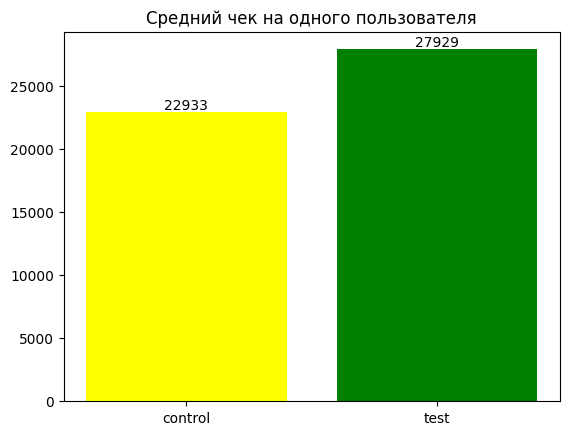

In [128]:
labels = ['control', 'test']  
values = [round(arpu_negative), round(arpu_positive)]  

# Создаю гистограмму 
bars = plt.bar(labels, values, color=['yellow', 'green'])  

# Добавляю заголовок и метки  
plt.title('Средний чек на одного пользователя')  
plt.ylabel('')  



# Добавляю метки значений в верхней части каждой панели  
for bar in bars:  
    yval = bar.get_height()  
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval}', ha='center', va='bottom')  
plt.show() 

2) Средний чек на покупку (AOV - Average Order Value)

In [129]:
# Расчет AOV



aov_positive = first_campaign_positive["cost"].mean()
aov_negative = first_campaign_negative["cost"].mean()

print(aov_positive)
print(aov_negative)

5201.096214710723
5465.121705051806


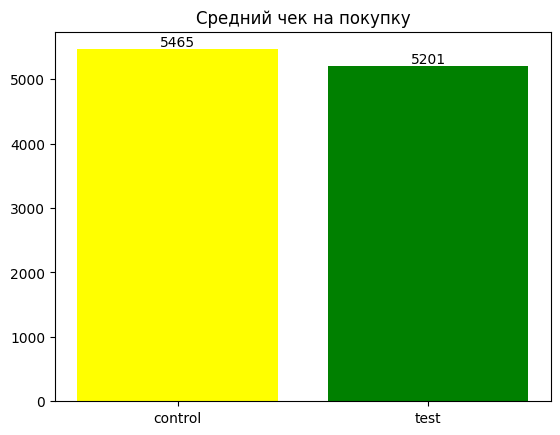

In [130]:
labels = ['control', 'test']  
values = [round(aov_negative), round(aov_positive)]  

# Создаю гистограмму 
bars = plt.bar(labels, values, color=['yellow', 'green'])  

# Добавляю заголовок и метки  
plt.title('Средний чек на покупку')  
plt.ylabel('')  



# Добавляю метки значений в верхней части каждой панели  
for bar in bars:  
    yval = bar.get_height()  
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval}', ha='center', va='bottom')  
plt.show() 

### Разница в сумме покупок

In [131]:
# Также хочу посмотреть на на графике разницу в суммарных покупках


c = np.array(first_campaign_negative.cost)
t = np.array(first_campaign_positive.cost)

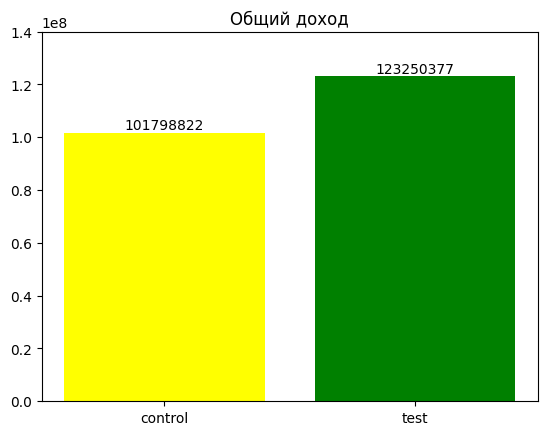

In [132]:
# Данные  
labels = ['control', 'test']  
values = [c.sum(), t.sum()]  

# Создаю гистограмму 
bars = plt.bar(labels, values, color=['yellow', 'green'])  

# Добавляю заголовок и метки  
plt.title('Общий доход')  
plt.ylabel('')  

# Установка делений по оси Y с шагом 20 миллионов
max_value = max(values)
yticks = list(range(0, int(max_value) + 20000000, 20000000))
plt.yticks(yticks)


# Добавляю метки значений в верхней части каждой панели  
for bar in bars:  
    yval = bar.get_height()  
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval}', ha='center', va='bottom')  
plt.show() 

## Вторая Кампания

In [137]:
second_campaign_yes = second_campaign[(second_campaign['dt'] == 15) | (second_campaign['dt'] == 45)]
second_campaign_no = second_campaign[(second_campaign['dt'] != 15) & (second_campaign['dt'] != 45)]

In [140]:
# Количество уникальных пользователей
num_users_yes = second_campaign_yes["id"].nunique()
num_users_no = second_campaign_no["id"].nunique()

# Средний чек (средняя стоимость покупки)
avg_cost_yes = second_campaign_yes["cost"].mean()
avg_cost_no = second_campaign_no["cost"].mean()



# Доля товаров со скидкой
discounted_purchases_yes = second_campaign_yes["base_sale"].sum() / len(second_campaign_yes)
discounted_purchases_no = second_campaign_no["base_sale"].sum() / len(second_campaign_no)

# Формируем DataFrame с метриками
metrics = pd.DataFrame({
    "Метрика": ["Количество пользователей", "Средний чек","Доля скидочных покупок"],
    "Воспользовались скидкой": [num_users_yes, avg_cost_yes, discounted_purchases_yes],
    "Не воспользовались скидкой": [num_users_no, avg_cost_no, discounted_purchases_no]
})

In [141]:
metrics

,Метрика,Воспользовались скидкой,Не воспользовались скидкой
0,Количество пользователей,5182.000000,23366.000000
1,Средний чек,5634.879002,5526.553340
2,Доля скидочных покупок,0.355637,0.364698


In [ ]:
labels = ['Воспользовались скидкой', 'Не воспользовались скидкой']
values = [5634.88, 5526.55]

# Построение графика среднего чека
plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=['blue', 'orange'])
plt.xlabel('Группа пользователей')
plt.ylabel('Средний чек (₽)')
plt.title('Сравнение среднего чека между группами')
plt.ylim(5000, 6000)

# Отображение графика
plt.show()

# A/B test

## Первая Кампания

### Гипотезы для теста на ARPU (Average Revenue Per User)

1) Нулевая гипотеза (H₀): Средний чек (ARPU) одинаков в обеих группах.

2) Альтернативная гипотеза (H₁): Средний чек (ARPU) различается между группами.

In [ ]:
t_stat_arpu, p_value_arpu = stats.ttest_ind(positive_users, negative_users, equal_var=False)
print(p_value_arpu)

ARPU значительно выше у пользователей, участвовавших в скидочной кампании (p-value < 0.05).

### Гипотезы для теста на AOV (Average Order Value)

1) Средний чек одной покупки не отличается между группами со скидками и без.

2) Альтернативная гипотеза (H₁): Средний чек одной покупки различается между группами.

In [ ]:
t_stat_aov, p_value_aov = stats.ttest_ind(first_campaign_positive["cost"], first_campaign_negative["cost"], equal_var=False)
print(p_value_aov)

p-value < 0.05, отвергаем H₀ → средний чек одной покупки (AOV) значимо отличается между группами.

## Вторая Кампания

In [ ]:
# A/B-тест: сравнение среднего чека
t_stat, p_value = ttest_ind(second_campaign_yes["cost"], second_campaign_no["cost"], equal_var=False)

# Вывод результатов A/B-теста
print("\nРезультаты A/B-теста (средний чек):")
print(f"T-статистика: {t_stat:.3f}")
print(f"P-значение: {p_value:.3f}")

if p_value < 0.05:
    print("Различие значимо (p < 0.05) → скидка повлияла на средний чек.")
else:
    print("Различие НЕ значимо (p >= 0.05) → скидка НЕ повлияла на средний чек.")

# Выводы

1) Средний чек (ARPU) в группе со скидками значительно выше, чем в группе без скидок.

2) Средний чек на покупку (AOV) немного ниже в группе со скидками, что ожидаемо, так как клиенты платили меньше за товары.

3) Скидки действительно увеличивают средний доход на пользователя (ARPU).

Однако средний чек покупки (AOV) снижается, что может означать, что клиенты покупают больше товаров, но с меньшей маржой.

текст

# Построение модели склонности клиента из города 1188 к покупке определённого товара

In [ ]:
# Оставляем только клиентов из города 1188



data_1188 = data[data['city']==1188]

In [ ]:
# В данных о типе продукта (product_type) есть следующие проблемы:
# 1) Разный регистр, из-за чего одни и теже данные считаются как разные
# 2) Множественное и единственное число. У одного и того же типа могут быть окончания (прим. Велосипед - Велосипеды)
# для этого уберу последние 2 символа
# 3) Есть один и тот же товар но с другим словом после тире. Оставлю только первое слово



data_1188['product_type'] = data_1188['product_type'].str.lower().str[:-2].str.split('-').str[0]

In [ ]:
# Создам копию таблицы для безопасной работы и добавлю колонку 'personal_coef' из таблицы personal_data_coeffs



data_1188_copy = data_1188.copy()
data_1188_copy = data_1188_copy.merge(
    personal_data_coeffs[['id', 'personal_coef']], 
    on='id', 
    how='inner')
data_1188_copy = data_1188_copy.drop(columns=['product','city','dt','id', 'cost'])

In [ ]:
category_counts = data_1188_copy["product_type"].value_counts()

# Выбираем только те категории, у которых 5 и более записей
valid_categories = category_counts[category_counts >= 5].index

# Фильтруем таблицу, оставляя только "достаточно популярные" категории
data_1188_copy = data_1188_copy[data_1188_copy["product_type"].isin(valid_categories)]

# Проверяем, что редкие категории удалены
print(data_1188_copy["product_type"].value_counts())

In [ ]:
data_1188_copy["product_type"].nunique()

### Создание модели

In [ ]:
# Дерево решения




for col in ['education', 'company', 'product_type', 'price_category', 'colour']:
    encoder = LabelEncoder()
    data_1188_copy[col] = encoder.fit_transform(data_1188_copy[col])



# Определяю цель для модели  
x = data_1188_copy.drop(['product_type'], axis=1)  
y = data_1188_copy['product_type'] 

scaler = StandardScaler()  
x_scaled = scaler.fit_transform(x) 
 
    
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)
 

dt = DecisionTreeClassifier()  
dt.fit(x_train, y_train)  
y_pred_dt = dt.predict(x_test) 

  
y_pred = dt.predict(x_test)  
print(classification_report(y_test, y_pred)) 

In [ ]:
# Случайный лес



for col in ['education', 'company', 'product_type', 'price_category', 'colour']:
    encoder = LabelEncoder()
    data_1188_copy[col] = encoder.fit_transform(data_1188_copy[col])



# Определяю цель для модели  
x = data_1188_copy.drop(['product_type'], axis=1)  
y = data_1188_copy['product_type'] 

scaler = StandardScaler()  
x_scaled = scaler.fit_transform(x) 
 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
 
model = RandomForestClassifier(random_state=42)  
model.fit(x_train, y_train)

  
y_pred = model.predict(x_test)  
print(classification_report(y_test, y_pred))

